In [2]:
import requests
import pandas as pd
from io import StringIO
import json

# API URL
url = "https://www.calmac.org/api.asp?data=weather&wmo=724830&year=2020&type=fin4"

# Get the raw text data
response = requests.get(url)
response.raise_for_status()  # Raise an error if request failed
data_text = response.text

# Split lines and extract header and units
lines = data_text.splitlines()
header_line = lines[1]  # 2nd row (index 1)
units_line = lines[2]   # 3rd row (index 2)
data_lines = lines[3:]  # from 4th row onwards

# Prepare column names (clean up whitespace)
headers = header_line.strip().split()
units = units_line.strip().split()

# Read data into DataFrame
data_str = "\n".join(data_lines)
df = pd.read_csv(StringIO(data_str), sep=r'\s+', engine='python', header=None)
df.columns = headers  # Apply headers from row 2

# Convert to JSON
data_json = df.to_dict(orient='records')

# Print JSON (pretty format)
print(json.dumps(data_json, indent=2))


ValueError: Length mismatch: Expected axis has 18 elements, new values have 11 elements

In [4]:
import requests
import pandas as pd
from io import StringIO
import json

# API URL
url = "https://www.calmac.org/api.asp?data=weather&wmo=724830&year=2020&type=fin4"

# Get the raw text data
response = requests.get(url)
response.raise_for_status()
data_text = response.text

# Split into lines
lines = data_text.splitlines()
header_line = lines[1]  # 2nd row: column headers
units_line = lines[2]   # 3rd row: units
data_lines = lines[3:]  # Data starts from 4th row

# Clean headers and units
headers = header_line.strip().split()
units = units_line.strip().split()

# Create DataFrame
data_str = "\n".join(data_lines)
df = pd.read_csv(StringIO(data_str), sep=r'\s+', engine='python', header=None)
df.columns = headers

# Combine data and units
data_with_units = []
for _, row in df.iterrows():
    record = {}
    for col, val in row.items():
        unit_index = headers.index(col)
        unit = units[unit_index] if unit_index < len(units) else None
        record[col] = {"value": val, "unit": unit}
    data_with_units.append(record)

# Output JSON
json_output = json.dumps(data_with_units, indent=2)
print(json_output)




ValueError: Length mismatch: Expected axis has 18 elements, new values have 11 elements

In [5]:
import requests
import pandas as pd
from io import StringIO

# API URL
url = "https://www.calmac.org/api.asp?data=weather&wmo=724830&year=2020&type=fin4"

# Get the data
response = requests.get(url)
response.raise_for_status()
lines = response.text.splitlines()

# Extract rows
raw_header = lines[1].strip().split()
raw_units = lines[2].strip().split()
data_lines = lines[3:]

# Load the full data
data_str = "\n".join(data_lines)
df = pd.read_csv(StringIO(data_str), sep=r'\s+', engine='python', header=None)

# Assign time and data headers separately
time_cols = ['Year', 'Mo', 'Dy', 'Hr']
data_headers = raw_units  # From row 3, used as actual column names
df.columns = time_cols + data_headers  # Combine time + data headers

# Extract (Hr, DBT)
if 'DBT' not in df.columns:
    raise KeyError("DBT column not found. Check unit row for exact label.")

df_hr_dbt = df[['Hr', 'DBT']]
print(df_hr_dbt.to_string(index=False))


ValueError: Length mismatch: Expected axis has 18 elements, new values have 23 elements

In [6]:
import requests
import pandas as pd
from io import StringIO

# API URL
url = "https://www.calmac.org/api.asp?data=weather&wmo=724830&year=2020&type=fin4"

# Fetch and split data
response = requests.get(url)
response.raise_for_status()
lines = response.text.splitlines()

# Extract lines
header_line = lines[1]  # row 2
unit_line = lines[2]    # row 3
data_lines = lines[3:]  # row 4+

# Clean and split header and unit lines
raw_headers = header_line.strip().split()
raw_units = unit_line.strip().split()

# Manually construct new column headers:
# 1. Add time variables
fixed_headers = ['Year', 'Mo', 'Dy', 'Hr']

# 2. Remove "Altim" from headers and units
if "Altim" in raw_headers:
    altim_index = raw_headers.index("Altim")
    raw_headers.pop(altim_index)
    raw_units.pop(altim_index)

# 3. Add remaining headers from modified header line
# (after "Hr", skip 1 removed "Altim", then continue)
fixed_headers += raw_headers[4:]

# Now read data into DataFrame
data_str = "\n".join(data_lines)
df = pd.read_csv(StringIO(data_str), sep=r'\s+', engine='python', header=None)

# Fix column count mismatch
if len(df.columns) != len(fixed_headers):
    raise ValueError(f"Column count mismatch: Data has {len(df.columns)}, headers have {len(fixed_headers)}")

df.columns = fixed_headers

# Print (Hr, DBT) format
for idx, row in df.iterrows():
    print(f"({int(row['Hr'])}, {row['DBT']})")


ValueError: Column count mismatch: Data has 18, headers have 10

In [7]:
import requests
import pandas as pd
from io import StringIO

# Step 1: Retrieve the data
url = "https://www.calmac.org/api.asp?data=weather&wmo=724830&year=2020&type=fin4"
response = requests.get(url)
raw_text = response.text

# Step 2: Extract header and unit rows
lines = raw_text.splitlines()
header_row = lines[1]
unit_row = lines[2]
data_lines = lines[3:]

# Step 3: Split the rows by whitespace
header_parts = header_row.split()
unit_parts = unit_row.split()

# Step 4: Adjust column names
# Use unit_parts for first 4 columns and last 4 columns
first_4 = unit_parts[:4]
last_4 = unit_parts[-4:]

# Use header_parts for the middle columns (excluding 'Altim')
middle_headers = header_parts[4:-5]  # exclude 'Altim' and one more to align with units
middle_units = unit_parts[4:-5]

# Find and remove "Altim" column if present
if "Altim" in middle_headers:
    altim_index = middle_headers.index("Altim")
    del middle_headers[altim_index]
    del middle_units[altim_index]

# Final column headers
final_headers = first_4 + middle_headers + last_4

# Step 5: Load data
data_str = "\n".join(data_lines)
df = pd.read_csv(StringIO(data_str), delim_whitespace=True, header=None)
df.columns = final_headers

# Step 6: Print only DBT data
print(df["DBT"])


/tmp/ipykernel_2620951/3749448286.py:40: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO(data_str), delim_whitespace=True, header=None)


ValueError: Length mismatch: Expected axis has 18 elements, new values have 10 elements

In [8]:
import requests
import pandas as pd
from io import StringIO

# Step 1: Get data from API
url = "https://www.calmac.org/api.asp?data=weather&wmo=724830&year=2020&type=fin4"
response = requests.get(url)
raw_text = response.text

# Step 2: Split into lines
lines = raw_text.splitlines()
header_row = lines[1].split()
unit_row = lines[2].split()
data_lines = lines[3:]

# Step 3: Construct proper headers
# First 4 columns: from unit row
first_4 = unit_row[:4]

# Middle columns: from header row, removing "Altim"
middle_raw = header_row[4:-4]
middle = [h for h in middle_raw if h != "Altim"]

# Last 4 columns: from unit row
last_4 = unit_row[-4:]

# Combine to form final header list
final_headers = first_4 + middle + last_4

# Step 4: Load data
data_str = "\n".join(data_lines)
df = pd.read_csv(StringIO(data_str), sep=r"\s+", header=None)

# Step 5: Assign headers (verify length matches)
assert len(df.columns) == len(final_headers), f"Mismatch: data has {df.shape[1]} columns, but header list has {len(final_headers)}"
df.columns = final_headers

# Step 6: Print DBT data
print(df["DBT"])


AssertionError: Mismatch: data has 18 columns, but header list has 11

In [9]:
import requests

# Step 1: Get data from API
url = "https://www.calmac.org/api.asp?data=weather&wmo=724830&year=2020&type=fin4"
response = requests.get(url)
lines = response.text.splitlines()

# Step 2: Extract header and unit rows
header_row = lines[1]
unit_row = lines[2]

print("HEADER ROW (row 2):")
print(repr(header_row))  # Use repr to visualize spaces
print("\nUNIT ROW (row 3):")
print(repr(unit_row))


HEADER ROW (row 2):
'                DBT    DPT    Press  Altim  Sky Opq WSpd  Wnd  SatGHI  SatDNI Pres                      '

UNIT ROW (row 3):
'Year Mo Dy Hr   (C)    (C)    (mb)   (inHg) Cov Cov (m/s) Dir  (W/m2) (W/m2)   Wth  Rain  Visib    Ceil  SolarZ'


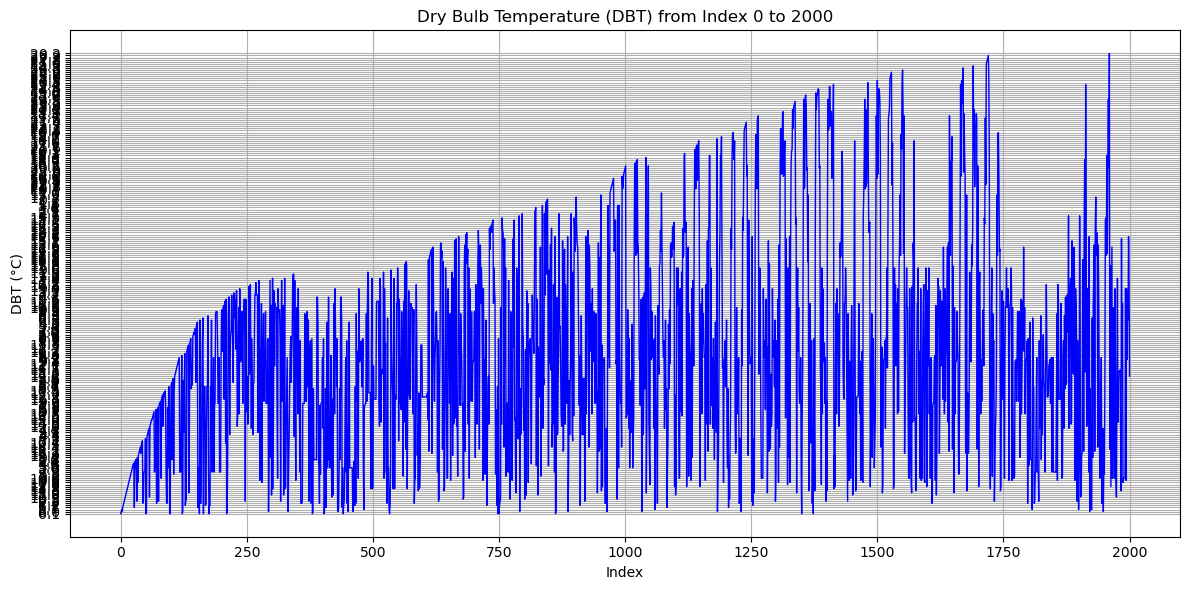

In [8]:
import requests
import pandas as pd
import re
from io import StringIO

# Step 1: Download and split data
url = "https://www.calmac.org/api.asp?data=weather&wmo=724830&year=2020&type=fin4"
response = requests.get(url)
lines = response.text.splitlines()

# Step 2: Extract rows
header_row = re.split(r'\s+', lines[1].strip())
unit_row = re.split(r'\s+', lines[2].strip())
data_lines = lines[3:]

# Step 3: Construct headers
# First 4 columns (time): from unit row
first_4 = unit_row[:4]

# Middle columns: from header_row (remove 'Altim')
middle = [col for col in header_row if col != 'Altim']

# Last 4 columns: from unit row
last_4 = unit_row[-4:]

# Final header list
final_headers = first_4 + middle + last_4

# Step 4: Load data into DataFrame
data_str = "\n".join(data_lines)
df = pd.read_csv(StringIO(data_str), sep=r'\s+', header=None)

# Verify header length
assert len(df.columns) == len(final_headers), f"Expected {len(df.columns)} headers, got {len(final_headers)}"

# Assign headers
df.columns = final_headers


import matplotlib.pyplot as plt

# Define range
start_idx = 0
end_idx = 2000

# Slice the DBT data
dbt_slice = df["DBT"].iloc[start_idx:end_idx+1]  # include end_idx

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(start_idx, end_idx + 1), dbt_slice, color='blue', linewidth=1)
plt.title("Dry Bulb Temperature (DBT) from Index 0 to 2000")
plt.xlabel("Index")
plt.ylabel("DBT (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()



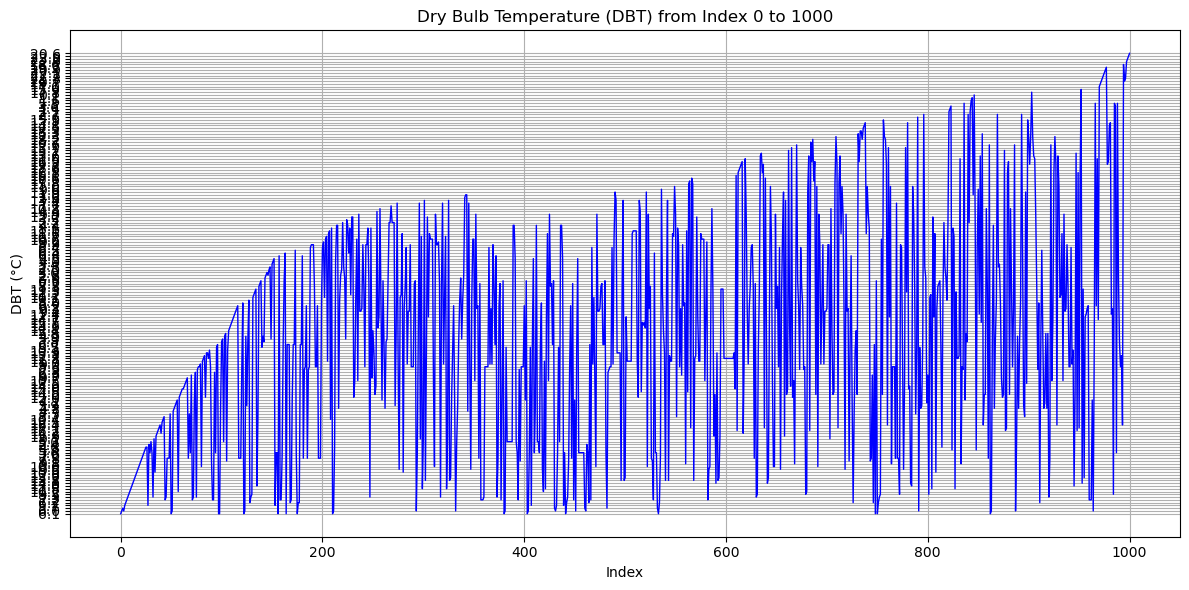

In [10]:
import requests
import pandas as pd
import re
from io import StringIO

# Step 1: Download and split data
url = "https://www.calmac.org/api.asp?data=weather&wmo=724830&year=2020&type=fin4"
response = requests.get(url)
lines = response.text.splitlines()

# Step 2: Extract rows
header_row = re.split(r'\s+', lines[1].strip())
unit_row = re.split(r'\s+', lines[2].strip())
data_lines = lines[3:]

# Step 3: Construct headers
# First 4 columns (time): from unit row
first_4 = unit_row[:4]

# Middle columns: from header_row (remove 'Altim')
middle = [col for col in header_row if col != 'Altim']

# Last 4 columns: from unit row
last_4 = unit_row[-4:]

# Final header list
final_headers = first_4 + middle + last_4

# Step 4: Load data into DataFrame
data_str = "\n".join(data_lines)
df = pd.read_csv(StringIO(data_str), sep=r'\s+', header=None)

# Verify header length
assert len(df.columns) == len(final_headers), f"Expected {len(df.columns)} headers, got {len(final_headers)}"

# Assign headers
df.columns = final_headers


import matplotlib.pyplot as plt

# Define range
start_idx = 0
end_idx = 1000

# Slice the DBT data
dbt_slice = df["DBT"].iloc[start_idx:end_idx+1]  # include end_idx

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(start_idx, end_idx + 1), dbt_slice, color='blue', linewidth=1)
plt.title("Dry Bulb Temperature (DBT) from Index 0 to 1000")
plt.xlabel("Index")
plt.ylabel("DBT (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()



DBT summary:
count    8769.000000
mean       16.886703
std         8.428789
min         0.000000
25%        10.500000
50%        16.000000
75%        22.300000
max        43.200000
Name: DBT, dtype: float64
15 missing values in DBT column.


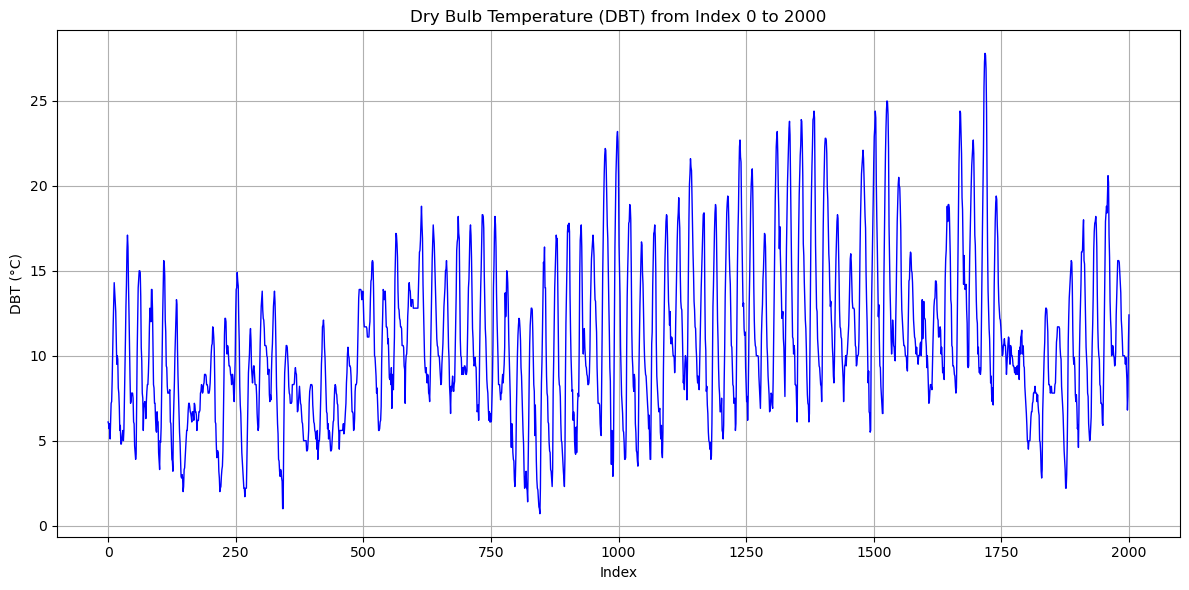

In [9]:
import requests
import pandas as pd
import re
from io import StringIO
import matplotlib.pyplot as plt

# Step 1: Download and split data
url = "https://www.calmac.org/api.asp?data=weather&wmo=724830&year=2020&type=fin4"
response = requests.get(url)
lines = response.text.splitlines()

# Step 2: Extract rows
header_row = re.split(r'\s+', lines[1].strip())
unit_row = re.split(r'\s+', lines[2].strip())
data_lines = lines[3:]

# Step 3: Construct headers
first_4 = unit_row[:4]
middle = [col for col in header_row if col != 'Altim']
last_4 = unit_row[-4:]
final_headers = first_4 + middle + last_4

# Step 4: Load data into DataFrame
data_str = "\n".join(data_lines)
df = pd.read_csv(StringIO(data_str), sep=r'\s+', header=None)

# Validate header length
assert len(df.columns) == len(final_headers), f"Expected {len(df.columns)} headers, got {len(final_headers)}"
df.columns = final_headers

# Step 5: Clean DBT column
df["DBT"] = pd.to_numeric(df["DBT"], errors='coerce')

# Optional: Report summary
print("DBT summary:")
print(df["DBT"].describe())
print(f"{df['DBT'].isna().sum()} missing values in DBT column.")

# Step 6: Define plot range
start_idx = 0
end_idx = 2000

# Step 7: Extract and plot
dbt_slice = df["DBT"].iloc[start_idx:end_idx + 1]

plt.figure(figsize=(12, 6))
plt.plot(range(start_idx, end_idx + 1), dbt_slice, color='blue', linewidth=1)
plt.title("Dry Bulb Temperature (DBT) from Index 0 to 2000")
plt.xlabel("Index")
plt.ylabel("DBT (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()
